In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from random import sample 
import matplotlib.pyplot as plt

import json
import os


#print(tf.__version__)
#print("gpu? ", tf.config.list_physical_devices('GPU'))
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [2]:
def plot_json(fname: str):
    with open(os.path.join(input_folder, file_name)) as json_file:
        stroke3data = json.load(json_file)    
    
    x = [0]
    y = [0]
    c = [0]
    i = 0
    
    for delta in np.array(stroke3data):
        i = i+1
        x.append(x[i-1] + delta[0]) 
        y.append(y[i-1] + delta[1]) 
        c.append(delta[3])

    plt.title(fname)
    plt.scatter(x, y, c=c)
    plt.show()



3200 sketches loaded. 10 random inputs:


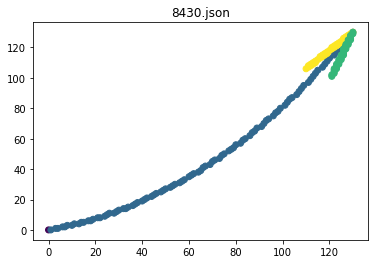

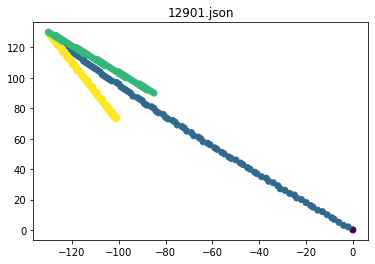

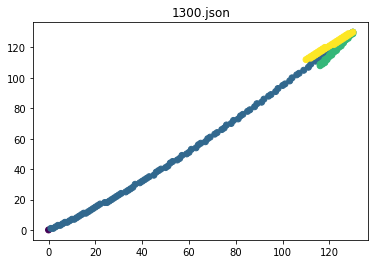

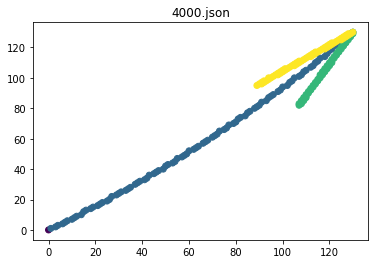

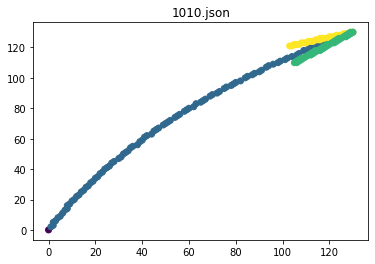

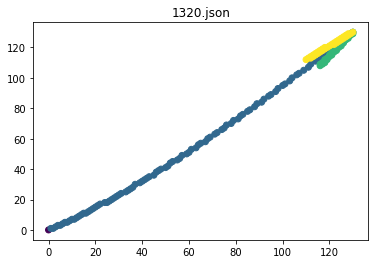

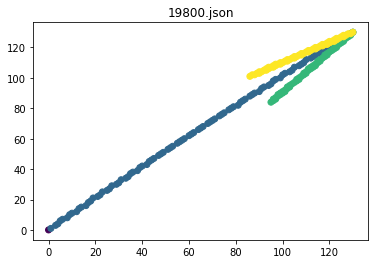

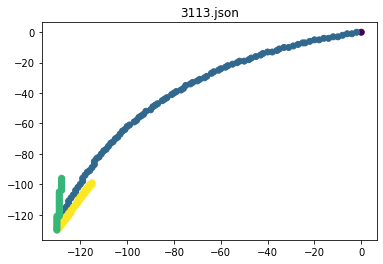

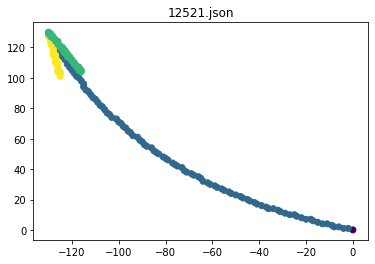

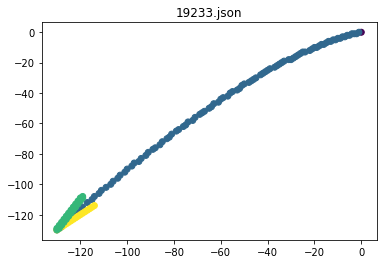

In [3]:
# input_folder = 'E:/prj/github/whiteboard/primitive-shapes/generated-data/training/arrow-stroke3'
input_folder = '/mnt/e/prj/github/whiteboard/primitive-shapes/generated-data/training/arrow-stroke3'

train_set = []
file_names = os.listdir(input_folder)
for file_name in file_names:
    if file_name.endswith('.json'):
        with open(os.path.join(input_folder, file_name)) as json_file:
            stroke3data = json.load(json_file)
            train_set.append(stroke3data)

            
print( str(len(train_set)) + ' sketches loaded. 10 random inputs:')

for file_name in sample(file_names,10):
    plot_json(file_name) 



In [4]:
# pad sketches with EOF token
points_in_sketch = len(max(train_set, key=len))

eof = [0, 0, 2, 0] # dx, dy, eos, label

for sketch in train_set:
    while len(sketch) < points_in_sketch:
        sketch.append(eof)

train_input = np.array(train_set).astype(float)

LABEL_CLASS_NUMBER = 5
train_labels = to_categorical(train_input[:,:,-1:], num_classes=LABEL_CLASS_NUMBER)
train_input = train_input[:,:,:-1]
print('train input shape: ' + str(train_input.shape))
print('train label shape: ' + str(train_labels.shape))

train input shape: (3200, 242, 3)
train label shape: (3200, 242, 5)


In [5]:
#strokes is array[number of sketches] of [number of points in sketch] of [dx, dy, end_of_stroke]
#inputs = keras.Input(shape=(None,), dtype="int32")

# Two layers of bidirectional LSTMs
rnn_dropout = 0.2
model = keras.models.Sequential([
    layers.Conv1D(filters=64, kernel_size=11, strides=1, padding="causal", activation="relu"),
    layers.Bidirectional(layers.LSTM(64, dropout=rnn_dropout, 
                                     return_sequences=True)),
    #layers.Bidirectional(layers.LSTM(128, dropout=rnn_dropout, return_sequences=True)), 
    layers.Dense(64, activation="relu"),
    #layers.Dense(20, activation="relu"),
    # Add a classifier
    
    layers.Dense(LABEL_CLASS_NUMBER, activation="softmax"),
    #layers.Lambda(lambda x: x * 400)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=["accuracy"])
history = model.fit(train_input, train_labels, epochs=5) #, callbacks=[lr_schedule])
print(model.summary())



Train on 3200 samples
Epoch 1/5
3200/3200 [==============================] - 34s 11ms/sample - loss: 0.4591 - accuracy: 0.7821
Epoch 2/5
3200/3200 [==============================] - 30s 9ms/sample - loss: 0.1783 - accuracy: 0.9214
Epoch 3/5
3200/3200 [==============================] - 30s 9ms/sample - loss: 0.1078 - accuracy: 0.9583
Epoch 4/5
3200/3200 [==============================] - 30s 9ms/sample - loss: 0.0781 - accuracy: 0.9717
Epoch 5/5
3200/3200 [==============================] - 30s 9ms/sample - loss: 0.0595 - accuracy: 0.9788
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              multiple                  2176      
_________________________________________________________________
bidirectional (Bidirectional multiple                  66048     
_________________________________________________________________
dense (Dense)                multiple    

test loaded: (1, 47, 3)
prediction received: (47, 5)
0
9
38 None None


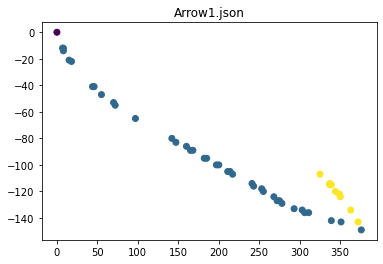

test loaded: (1, 211, 3)
prediction received: (211, 5)
0
76
135 None None


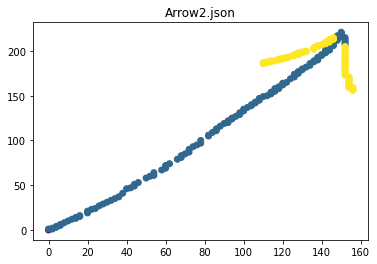

test loaded: (1, 427, 3)
prediction received: (427, 5)
35
100
292 None None


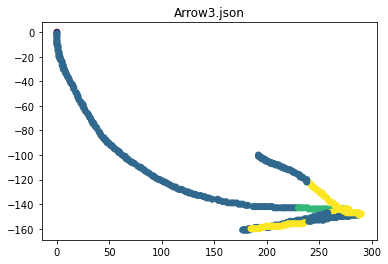

test loaded: (1, 171, 3)
prediction received: (171, 5)
12
39
120 None None


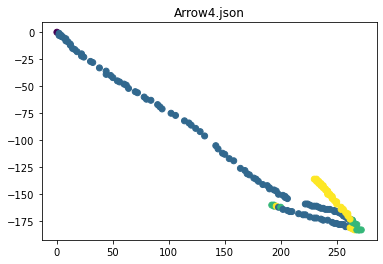

test loaded: (1, 170, 3)
prediction received: (170, 5)
29
43
98 None None


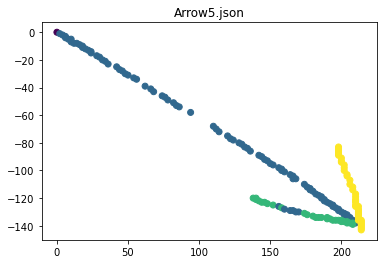

test loaded: (1, 231, 3)
prediction received: (231, 5)
43
90
98 None None


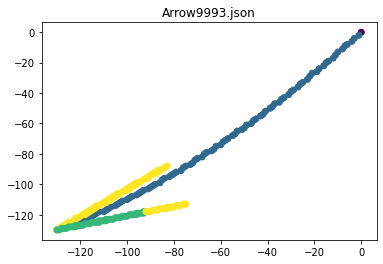

In [7]:


## Load test example
# test_folder = 'E:/prj/github/whiteboard/primitive-shapes/test/'
test_folder = '/mnt/e/prj/github/whiteboard/primitive-shapes/test/'

test_files = ['Arrow1.json', 'Arrow2.json', 'Arrow3.json', 'Arrow4.json', 'Arrow5.json', 'Arrow9993.json'] 

#with open('E:\prj\github\whiteboard\primitive-shapes\manual-data\Arrow2.json') as f:
#    curves = json.load(f)['requests'][0]['ink']
    
#for curve in curves:
#    plt.plot(curve[0], curve[1])
for test_file in test_files:    
    with open(test_folder + test_file) as json_file:
        test_data = np.array([json.load(json_file)])

    print('test loaded: ' + str(test_data.shape))

    prediction = model.predict(test_data)[0]
    print('prediction received: ' + str(prediction.shape))
    #print(prediction)

    decoded = np.argmax(prediction, axis=1)
    #print(decoded)
    print(decoded[decoded==1].sum(), print(int(decoded[decoded==2].sum()/2)), print(int(decoded[decoded==3].sum()/3)))

    x = [0]
    y = [0]
    c = [0]
    i = 0
    for delta in np.array(test_data[0]):
        i = i+1
        x.append(x[i-1] + delta[0]) 
        y.append(y[i-1] + delta[1]) 
        c.append(decoded[i-1])

    plt.title(test_file)
    plt.scatter(x, y, c=c)
    plt.show()
